In [1]:
from related_generator.post import Post
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import umap
from pathlib import Path
from tqdm.notebook import trange, tqdm
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
import nltk
import numpy as np
from multiprocessing import Pool
# from concurrent.futures import ThreadPoolExecutor
import time

nltk.download("punkt")
%matplotlib widget

[nltk_data] Downloading package punkt to /home/wint3rmute/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
import math
import markdown
import subprocess
from dataclasses import dataclass, field
from pathlib import Path

from bs4 import BeautifulSoup
from typing import Optional


@dataclass
class Post:
    title: str
    content: str
    path: Path

    related_links: list[str]
    
    tf_idf_position: list[float]
    lsa_position: list[float]
    
    # To be filled by map generation
    x: float = 0.0
    y: float = 0.0

    @classmethod
    def from_path(cls, path: Path):
        content_raw = path.read_text()
        html_tree = BeautifulSoup(content_raw, features="html.parser")
        
        # Get links from <nav>
        content_raw = path.read_text()
        html_tree = BeautifulSoup(content_raw, features="html.parser")
        nav_links = [l.attrs["href"] for l in html_tree.nav.find_all("a")]
        
        # Important: nav + footer MUST BE removed for later processing stages
        html_tree.nav.decompose()
        html_tree.footer.decompose()
        
        # Get 'Incoming' links
        incoming_links = cls.find_incoming_links(path, html_tree) or []
        
        content = html_tree.text.replace("\n", "")
        title = path.name

        to_trim = content.rfind("Incoming:")
        if to_trim != -1:
            content = content[to_trim:]
       
        related_links = list(set(nav_links) | set(incoming_links))
        return cls(title=title, content=content, path=path, related_links=related_links, tf_idf_position=None, lsa_position=None)
    
    @staticmethod
    def find_incoming_links(path, html_tree) -> Optional[list]:
        all_links = html_tree.find_all("a")[::-1]
        incoming_links = []
        for link in all_links:
            try:
                incoming_links.append(link.attrs["href"])
            except Exception as e:
                if link.text != "link" and link.text != "external link" and link.text != "local link":
                    raise ValueError(link)
                    raise e
            
            if "class" in link.attrs:
                return incoming_links

        # Executed if the links structure is atypical
        return None
    

    def distance_to(self, post: "Post") -> float:
        return math.sqrt((self.x - post.x) ** 2 + (self.y - post.y) ** 2)

    def distance_tf_idf(self, post: "Post") -> float:
        return np.linalg.norm(self.tf_idf_position - post.tf_idf_position)
    
    def distance_lsa(self, post: "Post") -> float:
        return np.linalg.norm(self.lsa_position - post.lsa_position)

def get_all_posts_oscean() -> list[Post]:
    all_posts_paths = Path.glob(Path("/home/wint3rmute/code/misc/oscean/site/"), "**/*.html")
    all_posts_paths = [path for path in all_posts_paths]

    with Pool() as p:
        all_posts = list(tqdm(p.map(Post.from_path, all_posts_paths), total=len(all_posts_paths)))
        return all_posts

all_posts = get_all_posts_oscean()

  0%|          | 0/462 [00:00<?, ?it/s]

In [3]:
def custom_tokenizer(text: str) -> list[str]:
    stemmer = SnowballStemmer("english")
    words = word_tokenize(text) 
    
    return [stemmer.stem(word) for word in words]

In [4]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from itertools import count


# Vectorizer to convert a collection of raw documents to a matrix of TF-IDF features
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)

# Learn vocabulary and idf, return term-document matrix.
tfidf = vectorizer.fit_transform([post.content for post in all_posts])

umap_result = umap.UMAP().fit_transform(
    tfidf
)

lsa = make_pipeline(TruncatedSVD(n_components=50), Normalizer(copy=False))
# t0 = time()
X_lsa = lsa.fit_transform(tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

# print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")


for post, post_position, post_index in zip(all_posts, umap_result, count()):
    post.x = post_position[0]
    post.y = post_position[1]
    post.tf_idf_position = tfidf[post_index]
    post.lsa_position = X_lsa [post_index]
    

Explained variance of the SVD step: 40.8%


In [17]:
str(vectorizer.transform(["generative music"])[0])

'  (0, 4685)\t0.7698231953372635\n  (0, 3261)\t0.6382571957453558'

In [5]:
hits = 0
all_comparisons = 0

for post in all_posts[2:]:
    posts_to_compare = [p for p in all_posts if p.title != post.title]
    closest_posts = sorted(posts_to_compare, key=lambda p: p.distance_lsa(post))[:len(post.related_links)]
    closest_posts_titles = [post.title for post in closest_posts]

    for related in post.related_links:
        if related in closest_posts_titles:
            hits += 1

        all_comparisons += 1
        
print("hits:  ", hits)
print("all:   ", all_comparisons)
print("ratio: ", hits/all_comparisons)

hits:   894
all:    5784
ratio:  0.1545643153526971


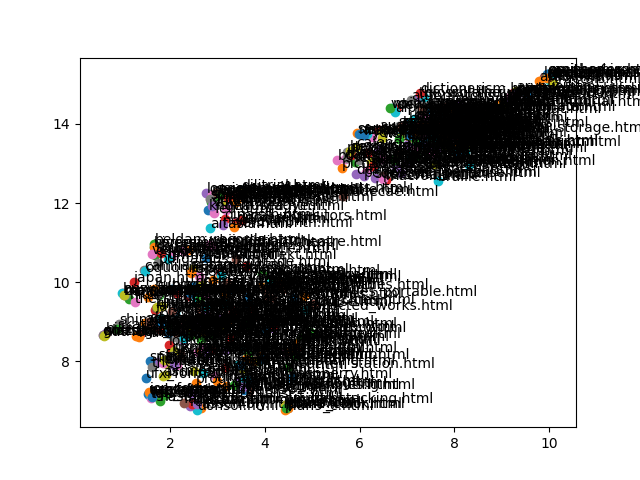

In [6]:
plt.close()

from itertools import count
import random
for post, post_position, post_index in zip(all_posts, umap_result, count()):
    plt.scatter(post_position[0], post_position[1])
    
    plt.annotate(post.title, post_position, post_position)

plt.show()